In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
data = pd.read_csv('advertising.csv')
data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


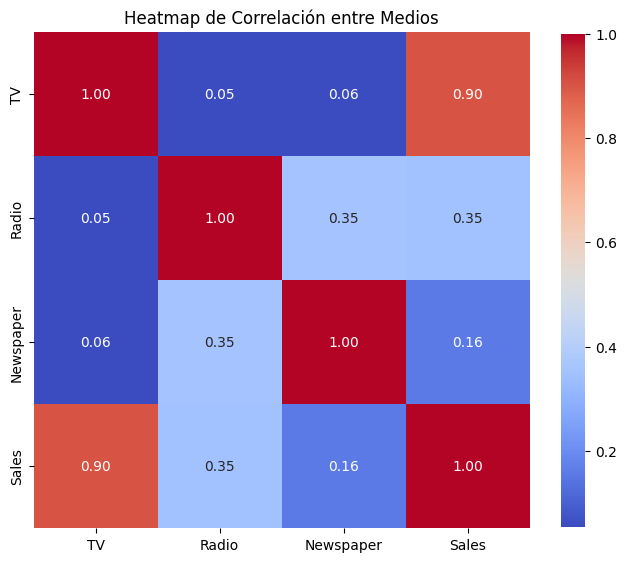

In [3]:
# Creando un heatmap para visualizar la correlación entre las variables

plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap de Correlación entre Medios')
plt.show()

In [4]:
# separando las variables independientes y dependientes
X = data[['TV', 'Radio', 'Newspaper']]
X= sm.add_constant(X)  # Agregar constante para el intercepto
Y = data['Sales']

In [5]:
# separando los datos en entrenamiento y prueba tomando el 70% para entrenamiento y 30% para prueba,
# y usando una semilla para asegurar la reproducibilidad del resultado.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [6]:
X_train_sm = sm.add_constant(X_train)
modelo = sm.OLS(Y_train, X_train_sm).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     405.2
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           1.36e-67
Time:                        23:54:28   Log-Likelihood:                -272.35
No. Observations:                 140   AIC:                             552.7
Df Residuals:                     136   BIC:                             564.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6614      0.368     12.650      0.0

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Entrenando el modelo de regresión lineal
modelo_sklearn = LinearRegression().fit(X_train, Y_train)
Y_pred = modelo_sklearn.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Error Cuadratico Medio: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Error Cuadratico Medio: 2.37
R^2 Score: 0.91


Predicción

In [8]:
nuevos_datos = pd.DataFrame({'const': [1],'TV': [100], 'Radio': [50], 'Newspaper': [70]})
nuevos_datos_sm = sm.add_constant(nuevos_datos)

In [9]:
# Obtener predicción e intervalo de confianza del 90%
pred_result = modelo.get_prediction(nuevos_datos_sm)
predicted_value = pred_result.predicted_mean[0]
intervalo = pred_result.conf_int(alpha=0.10)

# Extraer el límite inferior y superior
min_val = round(intervalo[0][0], 2)
max_val = round(intervalo[0][1], 2)

# Mostrar resultado completo
print(f"Predicción puntual de ventas: {round(predicted_value, 2)}")
print(f"Intervalo de confianza del 90%: \"{min_val} --- {max_val}\"")


Predicción puntual de ventas: 15.18
Intervalo de confianza del 90%: "14.59 --- 15.78"


Validacion de supuestos de la regresion

In [10]:
# Supuesto de normalidad de los residuos

import scipy
skew = float(scipy.stats.skew(modelo.resid, bias=True))
skew

-0.5262788252488133

In [11]:
kurtosis = float(scipy.stats.kurtosis(modelo.resid, fisher=True))
kurtosis

1.824267653812191

In [12]:
JB = (len(Y)/6) * (skew**2 + (kurtosis -3)**2/4)
JB

20.751867979111456

In [39]:
# Test de Jarque-Bera para normalidad de residuos
Nivel_confianza = 0.90
df_JB = 2  # Grados de libertad para Jarque-Bera (sesgo + curtosis)
valor_critico_JB = scipy.stats.chi2.ppf(Nivel_confianza, df=df_JB)

print(f"Test de Jarque-Bera:")
print(f"Estadístico JB: {JB:.4f}")
print(f"Valor crítico χ² (α=0.10, df={df_JB}): {valor_critico_JB:.4f}")

Test de Jarque-Bera:
Estadístico JB: 20.7519
Valor crítico χ² (α=0.10, df=2): 4.6052


Inexistencia de autocorrelacion entre residuales

In [14]:
from statsmodels.formula.api import ols

In [15]:
y_train_df = pd.DataFrame(Y_train)
x_train_df = pd.DataFrame(X_train[['TV', 'Radio', 'Newspaper']], columns=['TV', 'Radio', 'Newspaper'])
x_train_df

,TV,Radio,Newspaper
116,139.2,14.3,25.6
67,139.3,14.5,10.2
78,5.4,29.9,9.4
42,293.6,27.7,1.8
17,281.4,39.6,55.8
...,...,...,...
133,219.8,33.5,45.1
137,273.7,28.9,59.7
72,26.8,33.0,19.3
140,73.4,17.0,12.9


In [27]:
df_train = pd.concat([x_train_df, y_train_df], axis=1)
df_train.columns = ['TV', 'Radio', 'Newspaper', 'Sales']
df_train

,TV,Radio,Newspaper,Sales
116,139.2,14.3,25.6,12.2
67,139.3,14.5,10.2,13.4
78,5.4,29.9,9.4,5.3
42,293.6,27.7,1.8,20.7
17,281.4,39.6,55.8,24.4
...,...,...,...,...
133,219.8,33.5,45.1,19.6
137,273.7,28.9,59.7,20.8
72,26.8,33.0,19.3,8.8
140,73.4,17.0,12.9,10.9


In [17]:
# Crear modelo con los datos de entrenamiento para mantener consistencia
modelo_ols = ols('Sales ~ TV + Radio + Newspaper', data=df_train).fit()

# Calcular Durbin-Watson para detectar autocorrelación
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(modelo_ols.resid)
print(f"Estadístico Durbin-Watson: {dw:.4f}")

Estadístico Durbin-Watson: 2.0408


Homocedasticidad 

In [ ]:
# Homocedasticidad de los residuos

Resicuad = modelo.resid**2
Resicuad_df = pd.DataFrame(Resicuad, columns=['Residuos_Cuadrados'])
Resicuad

116    2.396553
67     0.157843
78     7.341130
42     8.721844
17     0.078137
         ...   
133    0.272288
137    3.218621
72     0.475858
140    0.227125
37     0.870775
Length: 140, dtype: float64

In [29]:
# Generar X1 con las columnas de medios de comunicación
X1 = df_train[['TV', 'Radio', 'Newspaper']].copy()
print("X1 (variables independientes):")
print(X1.head())
print()

# Calcular los valores al cuadrado
X1Cuad = X1**2
X1Cuad.columns = ['TV_Cuadrado', 'Radio_Cuadrado', 'Newspaper_Cuadrado']
print("X1 al cuadrado:")
print(X1Cuad.head())

X1Cuad

X1 (variables independientes):
        TV  Radio  Newspaper
116  139.2   14.3       25.6
67   139.3   14.5       10.2
78     5.4   29.9        9.4
42   293.6   27.7        1.8
17   281.4   39.6       55.8

X1 al cuadrado:
     TV_Cuadrado  Radio_Cuadrado  Newspaper_Cuadrado
116     19376.64          204.49              655.36
67      19404.49          210.25              104.04
78         29.16          894.01               88.36
42      86200.96          767.29                3.24
17      79185.96         1568.16             3113.64


,TV_Cuadrado,Radio_Cuadrado,Newspaper_Cuadrado
116,19376.64,204.49,655.36
67,19404.49,210.25,104.04
78,29.16,894.01,88.36
42,86200.96,767.29,3.24
17,79185.96,1568.16,3113.64
...,...,...,...
133,48312.04,1122.25,2034.01
137,74911.69,835.21,3564.09
72,718.24,1089.00,372.49
140,5387.56,289.00,166.41


In [31]:
df_aux =pd.concat([Resicuad_df, X1, X1Cuad], axis=1)
df_aux.columns = ['Residuos_Cuadrados', 'TV', 'Radio', 'Newspaper', 'TV_Cuadrado', 'Radio_Cuadrado', 'Newspaper_Cuadrado']
df_aux

,Residuos_Cuadrados,TV,Radio,Newspaper,TV_Cuadrado,Radio_Cuadrado,Newspaper_Cuadrado
116,2.396553,139.2,14.3,25.6,19376.64,204.49,655.36
67,0.157843,139.3,14.5,10.2,19404.49,210.25,104.04
78,7.341130,5.4,29.9,9.4,29.16,894.01,88.36
42,8.721844,293.6,27.7,1.8,86200.96,767.29,3.24
17,0.078137,281.4,39.6,55.8,79185.96,1568.16,3113.64
...,...,...,...,...,...,...,...
133,0.272288,219.8,33.5,45.1,48312.04,1122.25,2034.01
137,3.218621,273.7,28.9,59.7,74911.69,835.21,3564.09
72,0.475858,26.8,33.0,19.3,718.24,1089.00,372.49
140,0.227125,73.4,17.0,12.9,5387.56,289.00,166.41


In [32]:
model_aux = ols('Residuos_Cuadrados ~ TV + Radio + Newspaper + TV_Cuadrado + Radio_Cuadrado + Newspaper_Cuadrado', data=df_aux).fit()
RsgAux = model_aux.rsquared
RsgAux

np.float64(0.09260540518458005)

In [41]:
Estadistico = len(Y_train) * RsgAux
print(f"Estadístico de White: {Estadistico:.4f}")
print(f"R² auxiliar: {RsgAux:.4f}")

Estadístico de White: 12.9648
R² auxiliar: 0.0926


In [42]:
df_white = 6

Nivel_confianza = 0.90
valor_critico = scipy.stats.chi2.ppf(Nivel_confianza, df=df_white)
print(f"Valor crítico χ² (α=0.10, df={df_white}): {valor_critico:.4f}")
print()
print(f"Estadístico calculado: {Estadistico:.4f}")
print(f"Valor crítico: {valor_critico:.4f}")

Valor crítico χ² (α=0.10, df=6): 10.6446

Estadístico calculado: 12.9648
Valor crítico: 10.6446


In [18]:
import scipy.stats as stats
import statsmodels.stats.diagnostic as sms

residuos = modelo.resid
X_sm = modelo.model.exog

# Sesgo y curtosis
sesgo = stats.skew(residuos)
curtosis = stats.kurtosis(residuos)
print(f"Sesgo: {sesgo:.2f}")
print(f"Curtosis: {curtosis:.2f}")

# Durbin-Watson
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.2f}")

# Heterocedasticidad de White
white_test = sms.het_white(residuos, X_sm)
print(f"White Test p-value: {white_test[1]:.4f}")

Sesgo: -0.53
Curtosis: 1.82
Durbin-Watson: 2.04
White Test p-value: 0.0332


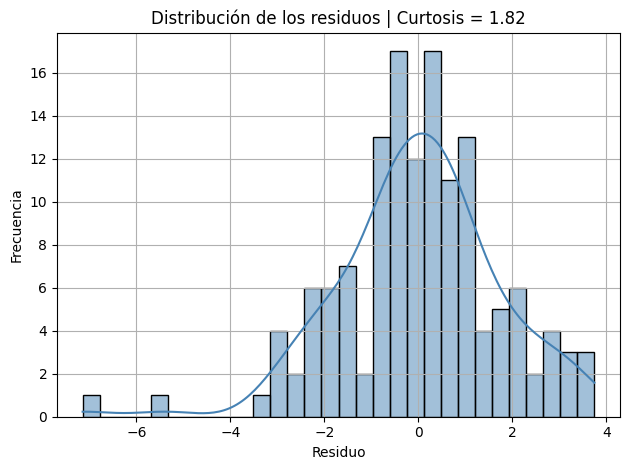

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma + KDE (curva de densidad)
sns.histplot(residuos, kde=True, bins=30, color='steelblue')
plt.title(f'Distribución de los residuos | Curtosis = {curtosis:.2f}')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()